In [2]:
#reading the csv file
import numpy as np
import pandas as pd 
#We are going to use the Apple AAPL Historical Stock Dataset and store the data in df variable. 
df=pd.read_csv('/content/HistoricalQuotes.csv')

In [3]:
df.head() #printing the first 5 rows.

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [4]:
#Printing the shape of the data and the datatypes of each features
df.shape , df.dtypes

((2518, 6), Date           object
  Close/Last    object
  Volume         int64
  Open          object
  High          object
  Low           object
 dtype: object)

In [5]:
#This will help us view the datatypes, missing values and many more insights of the dataset and its features.
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [6]:
#Now, lets select one feature to make the problem a univariate one. We will be selecting the Close/Last stock price. 
# For that we will use the df.iloc and select all the rows and, only the 2nd column.
# Lets see the new dataframe, df1 using df1.head()
df1 = df.iloc[:,3]
df1.head()

0     $257.26
1      $281.1
2     $286.53
3     $300.95
4     $297.26
Name:  Open, dtype: object

In [7]:
#We can see the data in the selected column are not numbers, rather they are objects (currency) as they have Dollar sign as the prefix. 
#Now, we will use regular expression to substitute the Dollar sign with a null '' and typecast the values to float. 
#Let's see how they will look after this preprocessing
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    257.26
1    281.10
2    286.53
3    300.95
4    297.26
Name:  Open, dtype: float64

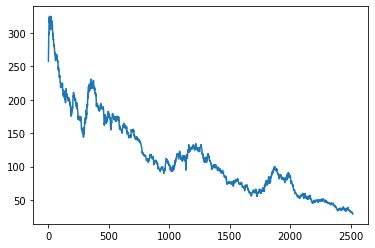

In [8]:
#Now, it is time to plot the data. Let's use plt.plot from the matplotlib library to plot the data and visualize the behavior.
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df1)

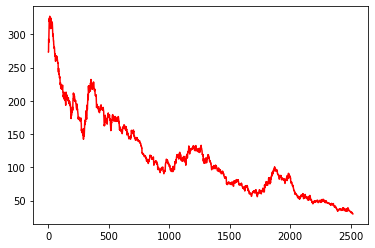

In [9]:
#Cleaning the data 
df1 = df.iloc[:,1]
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
plt.plot(df1, color='r')

In [12]:
#So, we have now a general idea of the stock price data's behavior. 
#Now, lets Normalize the data. Normalization is a very important part for any Recurrent Neural Network. 
#For our LSTM model, normalization will play an important role. 
#Normalization using MinMaxScaler will bring our entire datapoints between a minimum and a maximum value. 
#For this purpose, we will use the values (0,1).
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [13]:
df1.shape #Let's check the size

(2518,)

In [14]:
#It is clear that the df1 is a vector. 
#But the problem is MinMaxScaler works on numpy 2D arrays, not on vectors. 
#So, we will convert df1 to 2D array using np.array(df1).reshape(-1,1)) and then apply the scaling.
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
print('\n df1 present shape : ', df1.shape)


 df1 present shape :  (2518, 1)


In [16]:
#Train Test Split
#We will be using a 70%-30% train test split. But before applying splitting, we need to window the data. 
#For that, we will store the training and testing data and their shapes in some variables.
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1762
Test Size :  756


In [17]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1762, 1)
Test Data Shape:  (756, 1)


In [18]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [19]:
#Lest choose window size = 100 for now and apply the windowing on training and testing data.
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [20]:
#To make sure that the sliding window worked, lets check the shape. 
#If the dataset now do not have 100 columns then that means the windowing was not performed properly.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1661, 100) (1661,)
(655, 100) (655,)


In [21]:
#The training and testing data both have 100 columns in their independent variable (X) side. 
#At last, before passing the data to the model, 
#we need to reshape the data to make is 3D as LSTM are build to only accept 3D data.
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
#We will be using the Sequential, Dense and LSTM layers to build the model. 
#Ous model will be a stacked LSTM model. That means there will be more than one LSTM layer.
#As it is a regression like problem, so we will be using the loss='mean_squared_error'
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [24]:
model.summary()#Lets see the summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
#fitting the model by using batchsize=64 and epochs=100
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 10s 205ms/step - loss: 0.0217 - val_loss: 0.0105
Epoch 2/100
26/26 [==============================] - 4s 167ms/step - loss: 0.0014 - val_loss: 3.2409e-04
Epoch 3/100
26/26 [==============================] - 4s 168ms/step - loss: 5.4679e-04 - val_loss: 1.9659e-04
Epoch 4/100
26/26 [==============================] - 4s 166ms/step - loss: 5.0772e-04 - val_loss: 2.8753e-04
Epoch 5/100
26/26 [==============================] - 4s 170ms/step - loss: 4.8607e-04 - val_loss: 1.9053e-04
Epoch 6/100
26/26 [==============================] - 4s 172ms/step - loss: 4.8653e-04 - val_loss: 2.1236e-04
Epoch 7/100
26/26 [==============================] - 4s 167ms/step - loss: 4.6554e-04 - val_loss: 1.4629e-04
Epoch 8/100
26/26 [==============================] - 4s 167ms/step - loss: 4.4156e-04 - val_loss: 1.2795e-04
Epoch 9/100
26/26 [==============================] - 4s 168ms/step - loss: 4.3197e-04 - val_loss: 2.2681e-04
Epoch 10/100
26/26 [==========

In [26]:
#Now, as the model is trained, lets check its prediction on the test data. 
#We will store the prediction in y_pred, but as the data is scaled,
#so, we will inverse scale the data using scaler.inverse_transform() method.
y_pred = scaler.inverse_transform(model.predict(X_test))

In [27]:
#Lets also inverse scale the y_train data so that we can compare the data.
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [28]:
y_pred[:5]

array([[93.18573 ],
       [94.152756],
       [94.65213 ],
       [94.926414],
       [95.38178 ]], dtype=float32)

In [29]:
y_test[:5]

array([[94.4728],
       [94.1985],
       [95.3007],
       [97.3314],
       [95.0257]])

In [30]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  1.746963470562233


In [31]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.9912358510701741


No handles with labels found to put in legend.


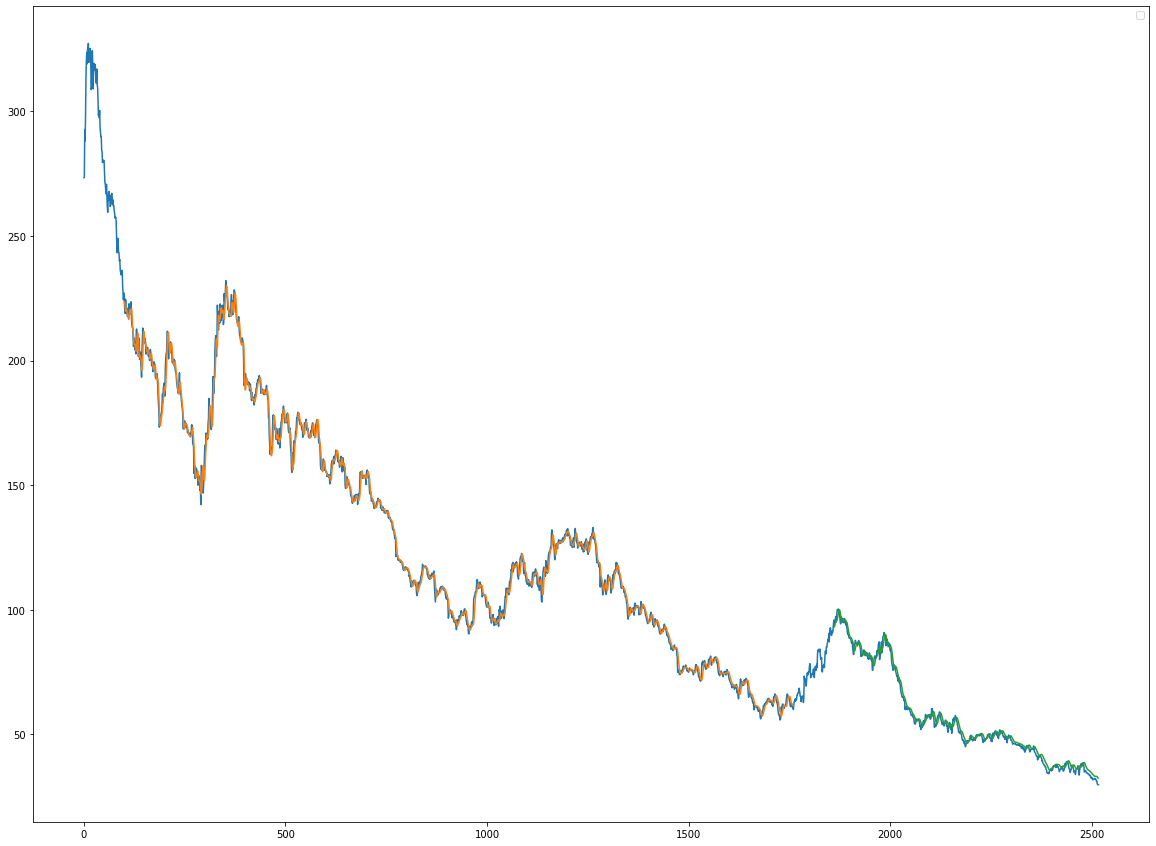

In [32]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [33]:
#predicting 60 days in future

#we need to predict each days values first, then use that value along with 99 others to make a series of 100 . 
#The following code does exactly that, and iteratively predicts the 60 days stock value. 
#The values are stored and finally displayed and visualized.

x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,161)

In [37]:
print(scaler.inverse_transform(lst_output))

[[31.82391196]
 [31.68989761]
 [31.73319265]
 [31.89519727]
 [32.11967738]
 [32.36843119]
 [32.62044905]
 [32.86640131]
 [33.10343493]
 [33.33167398]
 [33.55229104]
 [33.76663922]
 [33.9759227 ]
 [34.18114066]
 [34.38309237]
 [34.58241645]
 [34.77961472]
 [34.97506881]
 [35.16905844]
 [35.36176582]
 [35.55330561]
 [35.74372656]
 [35.93303752]
 [36.12121524]
 [36.30821539]
 [36.49398815]
 [36.67848253]
 [36.86164981]
 [37.04345343]
 [37.22386236]
 [37.40285668]
 [37.58043195]
 [37.75658373]
 [37.93131978]
 [38.10465673]
 [38.27661228]
 [38.44720639]
 [38.61646121]
 [38.7844    ]
 [38.95105045]
 [39.11642808]
 [39.28056279]
 [39.4434701 ]
 [39.60516772]
 [39.76567892]
 [39.92501256]
 [40.08318748]
 [40.24021697]
 [40.39611542]
 [40.55089282]
 [40.7045569 ]
 [40.85712651]
 [41.00861051]
 [41.15901776]
 [41.30835933]
 [41.45664298]
 [41.60388755]
 [41.75009414]
 [41.89527715]
 [42.03944434]]


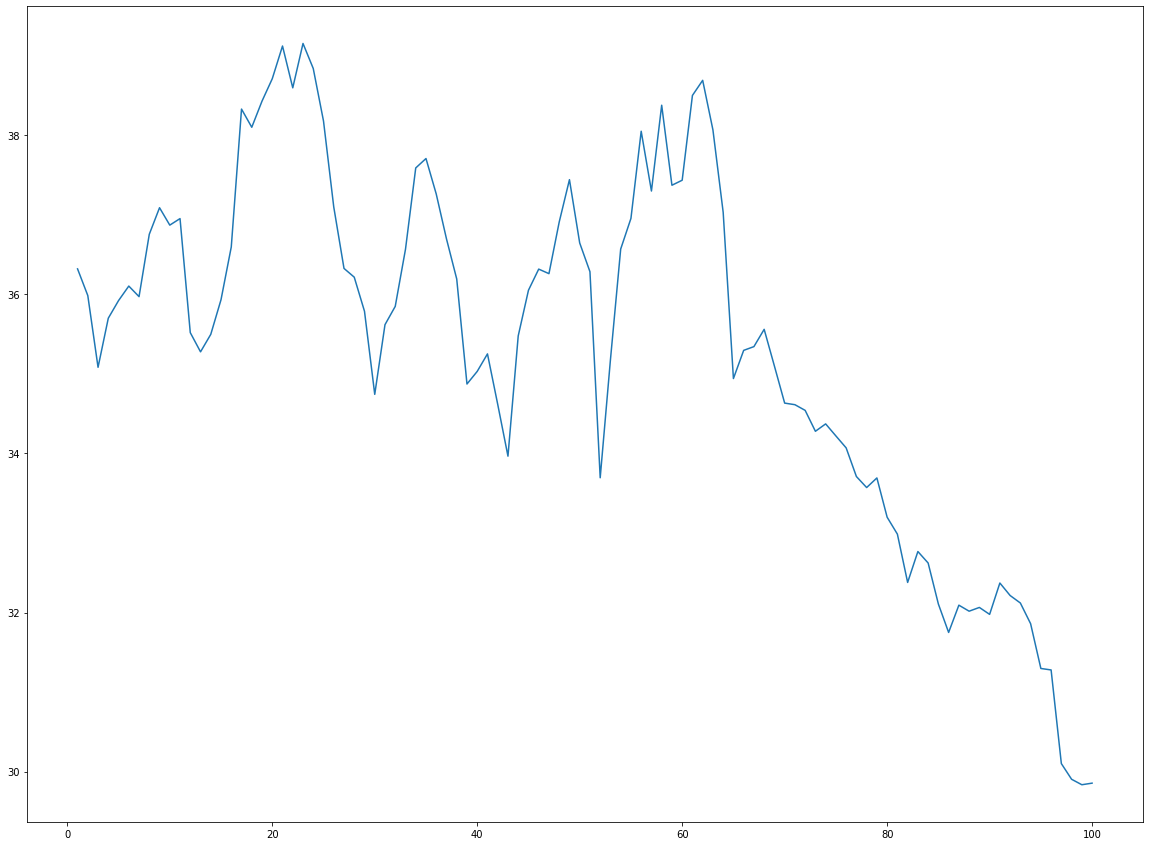

In [39]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
#plt.plot(day_pred,scaler.inverse_transform(lst_output))